In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
from getdata import netflix_df

In [16]:
condensed_df = netflix_df[["genres", "description"]]
condensed_df

,genres,description
0,['documentation'],This collection includes 12 World War II-era p...
1,"['drama', 'crime']",A mentally unstable Vietnam War veteran works ...
2,"['drama', 'action', 'thriller', 'european']",Intent on seeing the Cahulawassee River before...
3,"['fantasy', 'action', 'comedy']","King Arthur, accompanied by his squire, recrui..."
4,"['war', 'action']",12 American military prisoners in World War II...
...,...,...
5845,"['romance', 'drama']",A beautiful love story that can happen between...
5846,['drama'],A heart warming film that explores the concept...
5847,['comedy'],A controversial TV host and comedian who has b...
5848,[],"Jamie Foxx, David Alan Grier and more from the..."


In [39]:
genre_data = []

for row in list(condensed_df["genres"]):
    # re.sub() function taken from StackOverflow: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    clean = re.sub(r"[\[\]\' ]+\ *", "", row)
    clean2 = re.sub(r",", " ", clean)
    genre_list = list(clean2.split(" "))

    for genre in genre_list:
        if(not any(g["word"] == genre for g in genre_data)):
            #print("New word")
            genre_data.append({"word": genre, "count": 1})
        else:
            #print("Old word")
            genre_data[next((index for (index, g) in enumerate(genre_data) if g["word"] == genre), None)]["count"] += 1

genre_data.pop()
# sorted() function taken from StackOverflow: https://stackoverflow.com/questions/72899/how-to-sort-a-list-of-dictionaries-by-a-value-of-the-dictionary-in-python            
sorted_data = sorted(genre_data, key=lambda x: x['count'], reverse=True)
sorted_data

[{'word': 'drama', 'count': 2968},
 {'word': 'comedy', 'count': 2325},
 {'word': 'thriller', 'count': 1228},
 {'word': 'action', 'count': 1157},
 {'word': 'romance', 'count': 971},
 {'word': 'documentation', 'count': 952},
 {'word': 'crime', 'count': 936},
 {'word': 'animation', 'count': 705},
 {'word': 'family', 'count': 682},
 {'word': 'fantasy', 'count': 630},
 {'word': 'scifi', 'count': 589},
 {'word': 'european', 'count': 443},
 {'word': 'horror', 'count': 378},
 {'word': 'music', 'count': 262},
 {'word': 'history', 'count': 254},
 {'word': 'reality', 'count': 234},
 {'word': 'sport', 'count': 170},
 {'word': 'war', 'count': 163},
 {'word': 'western', 'count': 41}]

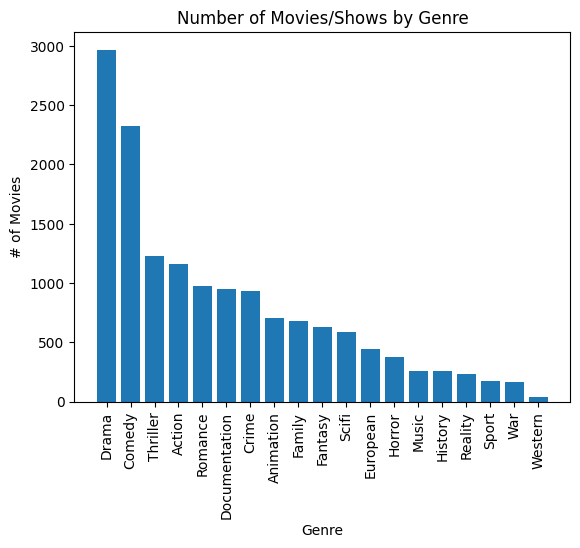

In [43]:
genres = [g["word"].capitalize() for g in sorted_data]
x_axis = np.arange(len(genres))
counts = [g["count"] for g in sorted_data]
plt.bar(x_axis, counts)
plt.xticks(x_axis, genres, rotation=90)
plt.title("Number of Movies/Shows by Genre")
plt.xlabel("Genre")
plt.ylabel("# of Movies")
plt.show()